In [10]:
"""
Written By: 
Rajeev Jain, 
jainraje@yahoo.com

For Technical Analysis of S&C Magazine article "Removing Moving Average Lag"

2025-01-21  Submitted various code blocks for May TraderTips article
2025-03-11  Cleaned up code to upload to github

"""

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
    
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

print(yf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.2.54


In [2]:
symbol = '^GSPC'
symbol = '^IXIC'
ohlcv = yf.download(symbol, start="2015-01-15", end="2025-01-29")
ohlcv

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC
Date,,,,,
2015-01-15,4570.819824,4663.959961,4567.390137,4657.459961,1976260000
2015-01-16,4634.379883,4635.819824,4563.109863,4566.379883,1970520000
2015-01-20,4654.850098,4665.649902,4601.100098,4655.839844,1835040000
2015-01-21,4667.419922,4692.459961,4629.589844,4641.950195,1847420000
2015-01-22,4750.399902,4752.600098,4644.569824,4690.930176,1996550000
...,...,...,...,...,...
2025-01-22,20009.339844,20068.519531,19903.050781,19903.050781,7219060000
2025-01-23,20053.679688,20053.679688,19892.550781,19906.990234,6837700000


In [3]:
def calc_sma(in_series, length):
    return in_series.rolling(length).mean()


def calc_pma(in_series, length):
    sma = calc_sma(in_series, length)
    slope = calc_slope(in_series, length)
    pma = (sma + slope * length / 2)
    return pma

def calc_slope(in_series, length):
    slope = in_series.rolling(length).apply(linear_regression_slope)
    return slope

def linear_regression_slope(samples):
    # Use numpy's polyfit to calculate the slope (1st degree polynomial)
    m, b = np.polyfit(np.arange(len(samples)), np.array(samples), 1)

    return m

def simple_plot1(df, length):
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close', color='black')
    plt.plot(df.index, df['SMA'], label=f'SMA - (Simple Moving Average - {length} days)', color='red', linestyle='-')
    plt.plot(df.index, df['PMA'], label=f'PMA - (Projected Moving Average - {length} days)', color='blue',
             linestyle='-')
    plt.title('S&P 500 Close vs PMA vs SMA', fontsize=14)
    plt.xlabel('')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()



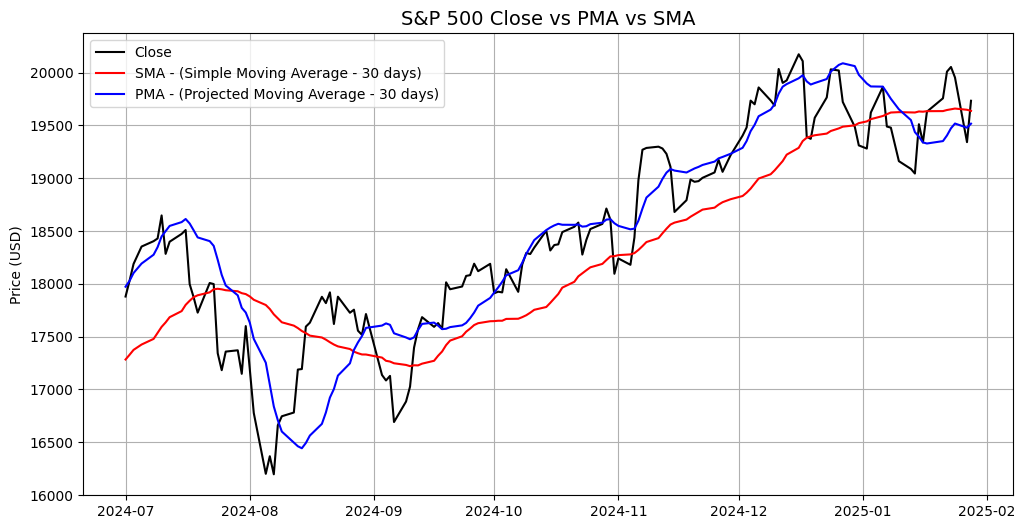

In [4]:
length = 30
df = ohlcv.copy()

df['SMA'] = calc_sma(df['Close'], length)
df['PMA'] = calc_pma(df['Close'], length)
#simple_plot1(df['2023-09':'2024-09-04'], length)
simple_plot1(df['2024-07':], length)

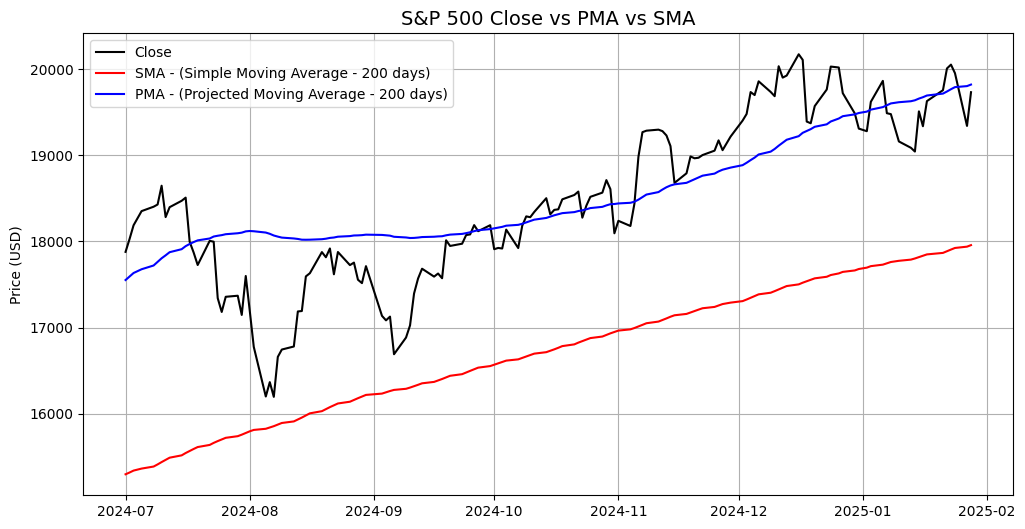

In [5]:
length = 200
df = ohlcv.copy()

df['SMA'] = calc_sma(df['Close'], length)
df['PMA'] = calc_pma(df['Close'], length)
simple_plot1(df['2024-07':], length)

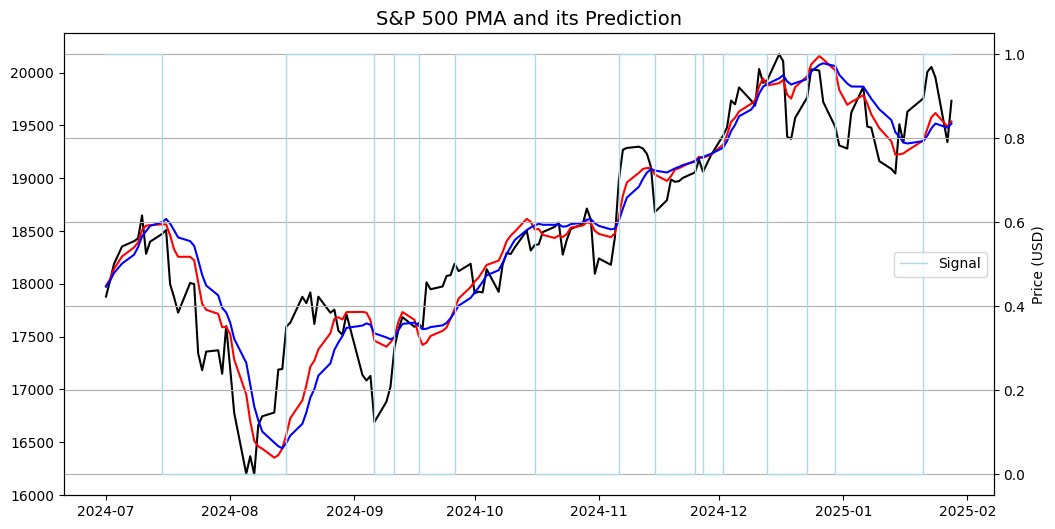

In [6]:
def calc_pma_prediction(pma, slope, length):
    # Predict = PMA + 0.5*(Slope - Slope[2])*Length
    predict = pma + (slope - slope.shift(2)) * length / 2

    return predict

def simple_plot2(df, length, signal_ena=False):
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close', color='black')
    plt.plot(df.index, df['Predict'], label=f'Predict - (PMA Predict - {length} days)', color='red', linestyle='-')
    plt.plot(df.index, df['PMA'], label=f'PMA - (Projected Moving Average - {length} days)', color='blue',
             linestyle='-')

    # Create a secondary y-axis to plot Signal
    if signal_ena:
        plt1 = plt.twinx()
        plt1.step(df.index, df['Signal'], label='Signal', color='lightblue', where='post', linestyle='-', linewidth=1)

    plt.title('S&P 500 PMA and its Prediction', fontsize=14)
    plt.xlabel('')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()


length = 30
df = ohlcv.copy()

df['SMA'] = calc_sma(df['Close'], length)
df['PMA'] = calc_pma(df['Close'], length)
#df['LRC'] = df['Close'].rolling(length).apply(linear_regression_curve)
df['Slope'] = df['Close'].rolling(length).apply(linear_regression_slope)
df['Predict'] = calc_pma_prediction(df['PMA'], df['Slope'], length)
df['Signal'] = np.where(df['Predict'] > df['PMA'], 1, 0)
simple_plot2(df['2024-07':], length, signal_ena=True)

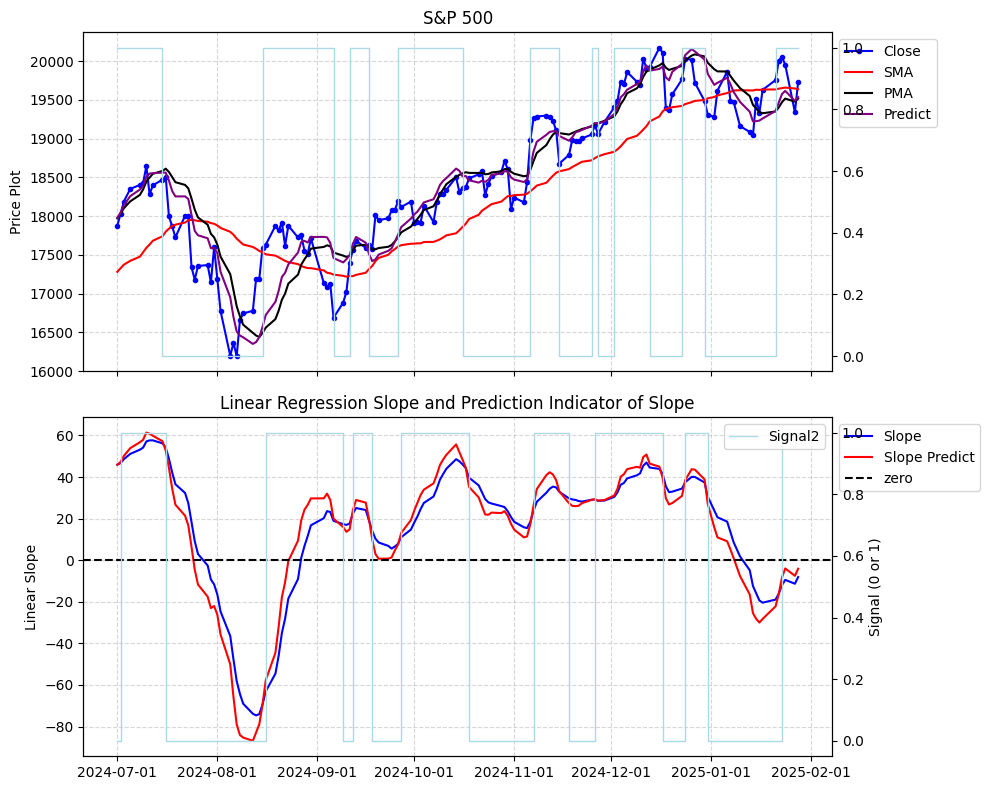

In [8]:
def calc_general_prediction(smooth):

    predict = 1.5*smooth - 0.5*smooth.shift(4)
    return predict

def simple_plot3(df, length, signal_ena=False):
    # Create a figure with two subplots stacked vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting the first subplot (e.g., Price Data)
    ax1.set_title(f"S&P 500")
    ax1.plot(df.index, df['Close'], label='Close', color='blue', marker='.')
    ax1.plot(df.index, df['SMA'], label='SMA', color='red')
    ax1.plot(df.index, df['PMA'], label='PMA', color='black')
    ax1.plot(df.index, df['Predict'], label='Predict', color='purple')

    if signal_ena:
        # Create a secondary y-axis to plot Signal
        ax1b = ax1.twinx()
        ax1b.step(df.index, df['Signal1'], label='Signal1', color='lightblue', where='post', linestyle='-', linewidth=1)

    ax1.set_ylabel('Price Plot')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Plotting the second subplot (Linear Regression Slope)
    ax2.set_title('Linear Regression Slope and Prediction Indicator of Slope')

    # Plot Slope on primary y-axis
    ax2.plot(df.index, df['Slope'], label='Slope', color='blue')
    ax2.plot(df.index, df['Slope Predict'], label='Slope Predict', color='red')
    ax2.axhline(y=0, color='black', linestyle='--', label='zero')

    if signal_ena:

        # Create a secondary y-axis to plot Signal
        ax2b = ax2.twinx()
        ax2b.step(df.index, df['Signal2'], label='Signal2', color='lightblue', where='post', linestyle='-', linewidth=1)
        ax2b.set_ylabel('Signal (0 or 1)')
    # Set labels for both y-axes

    ax2.set_ylabel('Linear Slope')

    # ax2.set_xlabel('Date')

    # Adjusting grids and legends
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    if signal_ena:
        ax2b.legend(loc='upper right', bbox_to_anchor=(1, 1))

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Improve overall layout
    plt.tight_layout()

    # Format x-axis date labels
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Optionally, add a title for the entire plot
    # fig.suptitle(f"Financial Data for {symbol}", fontsize=16)

    # Show the plot
    plt.show()


    
length = 30
df = ohlcv.copy()

df['SMA'] = calc_sma(df['Close'], length)
df['PMA'] = calc_pma(df['Close'], length)

#df['LRC'] = df['Close'].rolling(length).apply(linear_regression_curve)
df['Slope'] = df['Close'].rolling(length).apply(linear_regression_slope)
df['Predict'] = calc_pma_prediction(df['PMA'], df['Slope'], length)
df['Signal1'] = np.where(df['Predict'] > df['PMA'], 1, 0)

df['Slope Predict'] = calc_general_prediction(df['Slope'])
df['Signal2'] = np.where(df['Slope Predict'] > df['Slope'], 1, 0)
simple_plot3(df['2024-07':], length, signal_ena=True)

In [9]:
df.tail(15)

Price,Close,High,Low,Open,Volume,SMA,PMA,Slope,Predict,Signal1,Slope Predict,Signal2
Ticker,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,,,,,,,
Date,,,,,,,,,,,,
2025-01-06,19864.980469,20007.949219,19785.000000,19851.990234,9586840000,19589.222917,19867.394405,18.544766,19786.745205,0,9.118782,0
2025-01-07,19489.679688,19940.210938,19421.019531,19938.080078,13371130000,19606.464909,19811.195975,13.648738,19705.983910,0,5.217610,0
2025-01-08,19478.880859,19544.509766,19308.539062,19469.369141,8851720000,19622.305924,19752.330025,8.668273,19604.182636,0,1.041720,0
2025-01-10,19161.630859,19315.109375,19018.750000,19312.259766,8608880000,19625.865625,19652.604880,1.782617,19474.613068,0,-7.657512,0
2025-01-13,19088.099609,19099.970703,18831.910156,18903.660156,7830760000,19622.992253,19550.976030,-4.801081,19348.935708,0,-16.474005,0
2025-01-14,19044.390625,19273.140625,18926.599609,19207.750000,7168110000,19622.455924,19436.255122,-12.413387,19223.315065,0,-25.444449,0
2025-01-15,19511.230469,19548.900391,19299.320312,19350.310547,7260250000,19632.224609,19393.437363,-15.919150,19226.666339,0,-28.212861,0
2025-01-16,19338.289062,19579.849609,19335.679688,19573.869141,7085990000,19630.035938,19339.188620,-19.389821,19234.542105,0,-29.976040,0
